# Step 3 Climate Analysis & Exploration

In [1]:
# Import SQLAlchemy `automap` and other dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey
import numpy as np

In [2]:
# Create the connection engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# Declare a Base using `automap_base()`
BaseReflection = automap_base()

In [4]:
# reflect the tables
BaseReflection.prepare(engine, reflect=True)

In [5]:
#print classes mapped to the Base
BaseReflection.classes.keys()

['measurement', 'station']

In [6]:
# Reflect Database into ORM class
Measurement = BaseReflection.classes.measurement
Station = BaseReflection.classes.station

In [7]:
# Start a session to query the database
session = Session(engine)

# Precipitation Analysis

In [8]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [9]:
starting_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(starting_date)

2016-08-23


In [10]:
precipitation = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date>starting_date).\
                order_by(Measurement.date).all()

In [11]:
precipitation_df = pd.DataFrame(precipitation)
precipitation_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


In [12]:
precipitation_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


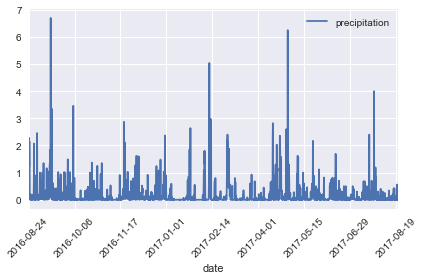

In [13]:
#Plot dataframe
precipitation_df.plot('date', 'prcp')
plt.xlabel("date")
plt.legend(["precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
#Summary Statistics
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis 

Total number of stations

In [15]:
session.query(Measurement).group_by(Measurement.station).count()

9

Most Active Stations

In [16]:
#List the stations and observation counts in descending order
active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).all()
print(active_stations)

[('USC00519281', 2772), ('USC00513117', 2696), ('USC00519397', 2685), ('USC00519523', 2572), ('USC00516128', 2484), ('USC00514830', 1937), ('USC00511918', 1932), ('USC00517948', 683), ('USC00518838', 342)]


In [17]:
#Which station has the highest number of observations?
most_active = active_stations[0][0]
print(most_active)

USC00519281


12 months of TOBS

In [18]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs).
#Filter by the station with the highest number of observations.
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                filter(Measurement.station == most_active).\
                filter(Measurement.date > starting_date).\
                order_by(Measurement.date).all()
temperature_df = pd.DataFrame(temperature)
temperature_df.head()

,station,date,tobs
0,USC00519281,2016-08-24,77
1,USC00519281,2016-08-25,80
2,USC00519281,2016-08-26,80
3,USC00519281,2016-08-27,75
4,USC00519281,2016-08-28,73


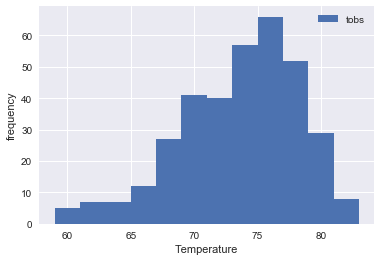

In [19]:
#Plot the results as a histogram with bins=12.
plt.hist(temperature_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("frequency")
plt.legend(["tobs"])
plt.show()

# Temperature Analysis

In [20]:
# calc_temps function
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.date >= start_date).filter(Measurement.date <=end_date).all()

In [21]:
# my trip previous year
previous_trip_start = dt.date(2016, 3, 1)
previous_trip_end = dt.date(2016, 3, 9)
temp_range = calc_temps(previous_trip_start, previous_trip_end)
print(temp_range)

[(62, 70.05882352941177, 78)]


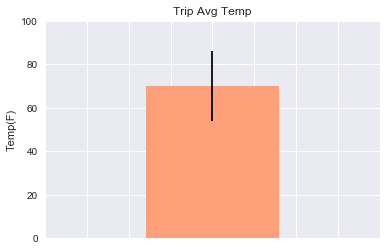

In [23]:
#plot bar chart
avg_temp = temp_range[0][1]
min_temp = temp_range[0][0]
max_temp = temp_range[0][2]
peak_to_peak = max_temp - min_temp
fig, ax = plt.subplots()
bar_chart = ax.bar(1, avg_temp, color = 'lightsalmon', yerr = peak_to_peak)
ax.set_ylabel('Temp(F)')
ax.set_title('Trip Avg Temp')
plt.ylim(0, 100)
plt.xlim(0, 2)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom='off',      
    top='off',         
    labelbottom='off')
plt.figure(figsize=(3,4))
plt.show()